In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import dice_ml
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split
import xgboost
import lightgbm
# import catboost
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from scipy.spatial.distance import euclidean, cityblock, mahalanobis
from sklearn.neighbors import LocalOutlierFactor as lof
import matplotlib
from matplotlib import font_manager as fm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#define data
df=pd.read_csv('German-Credit.csv')

In [4]:
df

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Class
0,D,C,D,C,D,D,N,D,C,B
1,INC,FIXED,FREE,FREE,FREE,FREE,FREE,FREE,FREE,PREDICT
2,67,male,2,own,0,1,1169,6,radio/TV,1
3,22,female,2,own,1,2,5951,48,radio/TV,0
4,49,male,1,own,1,0,2096,12,education,1
...,...,...,...,...,...,...,...,...,...,...
997,31,female,1,own,1,0,1736,12,furniture/equipment,1
998,40,male,3,own,1,1,3857,30,car,1
999,38,male,2,own,1,0,804,12,radio/TV,1
1000,23,male,2,free,1,1,1845,45,radio/TV,0


In [5]:
dataset = df.loc[2:,:]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 2 to 1001
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              1000 non-null   object
 1   Sex              1000 non-null   object
 2   Job              1000 non-null   object
 3   Housing          1000 non-null   object
 4   SavingAccounts   1000 non-null   object
 5   CheckingAccount  1000 non-null   object
 6   CreditAmount     1000 non-null   object
 7   Duration         1000 non-null   object
 8   Purpose          1000 non-null   object
 9   Class            1000 non-null   object
dtypes: object(10)
memory usage: 78.3+ KB


In [6]:
dataset[['Age', 'Duration','Job', 'SavingAccounts','CheckingAccount','CreditAmount']]=dataset[['Age', 'Duration','Job', 'SavingAccounts','CheckingAccount','CreditAmount']].astype('int')
dataset[['Class']]=dataset[['Class']].astype('int')

c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [7]:
def FFN():
    clf = MLPClassifier(solver='sgd', alpha=1e-5,
                 hidden_layer_sizes=(5, 2), random_state=13)
    return clf

In [8]:

target = dataset["Class"] 

train_dataset, test_dataset,y_train,__ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)


train_dataset, val_dataset,_,__ = train_test_split(train_dataset,
                                                    y_train,
                                                     test_size=0.1,
                                                     random_state=0,
                                                     stratify=y_train)
# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=['Age', 'Duration','Job', 'SavingAccounts','CheckingAccount','CreditAmount'],
                 outcome_name='Class')

In [9]:
def preprocess(numerical,categorical):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    transformations = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical),
            ('cat', categorical_transformer, categorical)])
    return transformations

In [10]:
def reset_data(dataset,model):
    target = dataset["Class"]
    # Split data into train and test
    datasetX = dataset.drop("Class", axis=1)
    x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                        target,
                                                        test_size=0.2,
                                                        random_state=0,
                                                        stratify=target)
    x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                        y_train,
                                                        test_size=0.1,
                                                        random_state=0,
                                                        stratify=y_train)

    numerical = ['Age', 'Duration','Job', 'SavingAccounts','CheckingAccount','CreditAmount']
    categorical = x_train.columns.difference(numerical)

    # We create the preprocessing pipelines for both numeric and categorical data.
    

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocess(numerical,categorical)),
                        ('classifier', model)])
    model = clf.fit(x_train, y_train)

    return x_train,x_val,x_test,y_train,y_val,y_test,model

In [11]:
def gen_cf(x_test,model,method):
           
    x_test=x_test.reset_index(drop=True)
    cf_list=pd.DataFrame(columns=(x_test.columns).to_list()+['ce_class'])
    backend = 'sklearn'
    m = dice_ml.Model(model=model, backend=backend)
    exp = dice_ml.Dice(d, m, method=method)

    for i in range(len(x_test)):
        query_instances=x_test[i:i+1]
        # print(query_instances)
        try:
            dice_exp = exp.generate_counterfactuals(query_instances, total_CFs=2, desired_class="opposite", verbose=False)
            cf_list.loc[i,:]=dice_exp.cf_examples_list[0].final_cfs_df.values[0]#[0:-1]
        except:
             default=np.append(query_instances.values,[1])
             cf_list.loc[i,:]=default
    
    return cf_list
        

In [12]:
#get random training instances from x_val
def get_new_data(data,y,n):
    data=data.reset_index(drop=True)
    y=y.reset_index(drop=True)
    if n<=len(data):
        idx = np.random.choice(data.index, n, replace=False)
        # print(idx)
        return data[data.index.isin(idx)],y[y.index.isin(idx)]
    else:
        print('check n')

In [13]:
def dist(x_test,cf_list,d='L2'):
    dist_val=[]
    for i in range(len(x_test)):
        query=x_test[i]
        cf=cf_list[i]
        if d=='L2':
            distance=euclidean(query,cf)
        elif d=='L1':
            distance=cityblock(query,cf)
        elif d=='mahalanobis':
            distance=mahalanobis(query,cf)
        else:
            distance=0
        dist_val.append(distance)

    return sum(dist_val)/len(dist_val)

In [14]:
def cal_lof(cf_list,x_train,y_train,cls):
    idx=[]
    for i in range(len(y_train.values)):
        if y_train.values[i]==cls:
            idx.append(i)
    
    datx=np.take(x_train.values,idx,axis=0)
    numerical = ['Age', 'Duration','Job', 'SavingAccounts','CheckingAccount','CreditAmount']
    categorical = x_train.columns.difference(numerical)
    transformations=preprocess(numerical,categorical)
    clf = Pipeline(steps=[('preprocessor',transformations)])
    
    lof_cal = lof(n_neighbors=10)
    dat=np.vstack((datx,cf_list.values[:,:9]))
    d=pd.DataFrame(dat,columns=x_train.columns.to_list())
    dat=clf.fit_transform(d)
    lof_cal.fit(dat)
    nof=lof_cal.negative_outlier_factor_[len(datx):]
    # print(nof.shape)

    return sum(nof)/len(nof)

In [15]:
def remove_data(data,y,n):#needs checking
    remove_n = n
    data=data.reset_index(drop=True)
    y=y.reset_index(drop=True)
    drop_indices = np.random.choice(data.index, remove_n, replace=False)

    dat=data.drop(drop_indices,inplace=True,axis=0)
    y=y.drop(drop_indices,inplace=True,axis=0)

    return dat, y

In [16]:
def check_sr(model,cf,x_test,y_test):
    pred=model.predict(cf)
    idx=[]
    for i in range(len(cf)):
        if pred[i]!=y_test.values[i]:
            idx.append(i)
        else:
            pass
    cf=cf.reset_index(drop=True)
    x_test=x_test.reset_index(drop=True)
    y_test=y_test.reset_index(drop=True)
    cf=cf[cf.index.isin(idx)]
    x_test=x_test[x_test.index.isin(idx)]
    y_test=y_test[y_test.index.isin(idx)]
    return cf, x_test,y_test,len(idx)/len(y_test)


In [17]:
def validity_check(model,cf_list,x_train,y_train,x_val,y_val,x_test,y_test):    
    validity_dict={}
    acc_dict={}
    lof_dict={}
    dist_dict={}
    
    for i in range(0,80,5): #change this according to the dataset's val set size
        a,b = get_new_data(x_val,y_val,i)
        x_train_new=x_train.append(a)
        y_train_new=y_train.append(b)

        # x_train_new_cp=x_train_new
        lof_dict[str(i)] = cal_lof(cf_list,x_train_new,y_train_new,1)
        numerical = ['Age', 'Duration','Job', 'SavingAccounts','CheckingAccount','CreditAmount']
        categorical = x_train.columns.difference(numerical)
        transformations=preprocess(numerical,categorical)
        clf = Pipeline(steps=[('preprocessor',transformations),
                        ('classifier', model)])
        clf2=Pipeline(steps=[('preprocessor',transformations)])
        model_new = clf.fit(x_train_new, y_train_new)
        clf2.fit(x_train_new)
        x_test2=clf2.transform(x_test)
        cf_list2=clf2.transform(cf_list.iloc[:,:9])

        preds=model_new.predict(cf_list.iloc[:,:9])
        preds_original=model_new.predict(x_test)
        dist_dict[str(i)] = dist(x_test2,cf_list2)
        
        cf_list['pred_new']=preds
        valdity=sum(abs(cf_list[['ce_class']].values.astype('int')-cf_list[['pred_new']].values.astype('int')))/len(x_test)
        validity_dict[str(i)] = valdity[0]        
        acc_dict[str(i)]=accuracy_score(y_test,preds_original)

    return validity_dict,acc_dict,lof_dict,dist_dict

In [18]:
#%%capture
models={'rf':RandomForestClassifier(random_state=13),'xgb':xgboost.XGBClassifier(random_state=13),'lgb':lightgbm.LGBMClassifier(random_state=13),'adb':AdaBoostClassifier(random_state=13),'ffn':FFN()}
methods=['random']
validity_dict_per_model={}
acc_dict_per_model={}
lof_dict_per_model={}
dist_dict_per_model={}
sr_dict_per_model={}
for name,model_init in models.items():
    if model_init=='':
        continue
    else:
        val_dict_per_m={}
        acc_dict_per_m={}
        dist_dict_per_m={}
        lof_dict_per_m={}
        sr_dict_per_m={}
        for m in methods:
            x_train,x_val,x_test,y_train,y_val,y_test,model = reset_data(dataset,model_init)
            cf = gen_cf(x_test,model,m)
            cf,x_test,y_test,sr=check_sr(model,cf,x_test,y_test)
            sr_dict_per_m=sr
            print('Checking validity for ',name,' with ',m)
            val_dict_per_m[m],acc_dict_per_m[m],lof_dict_per_m[m],dist_dict_per_m[m]=validity_check(model_init,cf,x_train,y_train,x_val,y_val,x_test,y_test)
        validity_dict_per_model[name]=val_dict_per_m
        acc_dict_per_model[name]= dict(pd.DataFrame(list(acc_dict_per_m.values())).mean())
        lof_dict_per_model[name]=lof_dict_per_m
        dist_dict_per_model[name]=dist_dict_per_m
        sr_dict_per_model[name]=sr_dict_per_m
            
            

100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Checking validity for  rf  with  random


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Checking validity for  xgb  with  random
[LightGBM] [Info] Number of positive: 504, number of negative: 216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 720, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Checking validity for  lgb  with  random
[LightGBM] [Info] Number of positive: 504, number of negative: 216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 720, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Checking validity for  adb  with  random


c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Checking validity for  ffn  with  random


c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dell\miniconda3\envs\robust\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dell\miniconda3

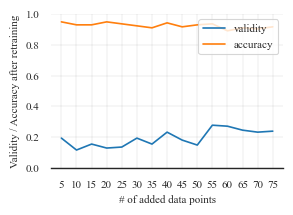

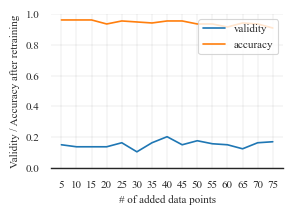

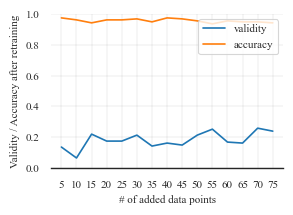

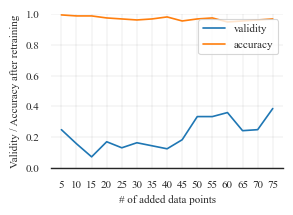

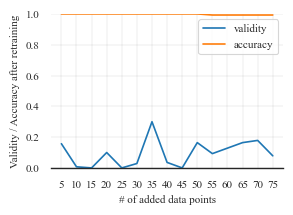

In [36]:
for names,_ in validity_dict_per_model.items():    
    # validity_dict_gen=validity_dict_per_model[names]['genetic']
    validity_dict_rand=validity_dict_per_model[names]['random']
    # validity_dict_kdt=validity_dict_per_model[names]['kdtree']
    acc=acc_dict_per_model[names]
    xval=validity_dict_per_model[names]['random'].keys()
    plt.figure(figsize=(3,2))
    # plt.plot(xval,validity_dict_gen.values(),label='genetic')
    plt.plot(list(xval)[1:],list(validity_dict_rand.values())[1:],label='validity')
    # plt.plot(xval,validity_dict_kdt.values(),label='kdtree')
    plt.plot(list(xval)[1:],list(acc.values())[1:],label='accuracy')


    plt.xlabel('# of added data points', fontname='Times New Roman',fontsize=8)#fontweight='bold')fontname='Times New Roman',
    plt.ylabel('Validity / Accuracy after retraining',fontname='Times New Roman',fontsize=8)#, fontweight='bold')
    plt.xticks(rotation=0, fontname='Times New Roman',fontsize=8)#, fontweight='bold')
    plt.yticks(fontname='Times New Roman',fontsize=8)
    plt.ylim((0,1))
    # plt.xlim((5,100))
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1)
    plt.grid(True, linestyle='-', linewidth=0.1, color='gray')

    font = fm.FontProperties(family='Times New Roman', size=8) #) weight='bold')

    plt.legend(prop=font, loc='upper right')

    sns.despine(right=True, left=True, top=True)
    # plt.title(names+' and DiCE')
    plt.show()

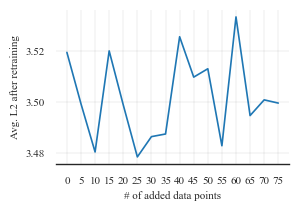

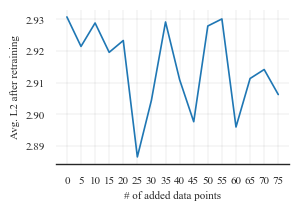

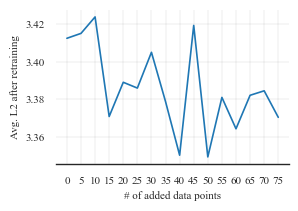

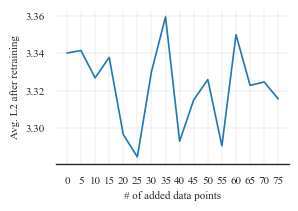

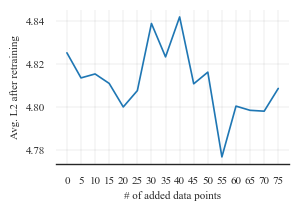

In [20]:
for names,_ in dist_dict_per_model.items():    
    # dist_dict_gen=dist_dict_per_model[names]['genetic']
    dist_dict_rand=dist_dict_per_model[names]['random']
    # dist_dict_kdt=dist_dict_per_model[names]['kdtree']
    acc=acc_dict_per_model[names]
    xval=dist_dict_per_model[names]['random'].keys()
    plt.figure(figsize=(3,2))
    # plt.plot(xval,dist_dict_gen.values(),label='genetic')
    plt.plot(xval,dist_dict_rand.values(),label='')
    # plt.plot(xval,dist_dict_kdt.values(),label='kdtree')
    # plt.plot(xval,acc.values(),label='accuracy')
    plt.xlabel('# of added data points', fontname='Times New Roman',fontsize=8)#fontweight='bold')fontname='Times New Roman',
    plt.ylabel('Avg. L2 after retraining',fontname='Times New Roman',fontsize=8)#, fontweight='bold')
    plt.xticks(rotation=0, fontname='Times New Roman',fontsize=8)#, fontweight='bold')
    plt.yticks(fontname='Times New Roman',fontsize=8)
    # plt.ylim((0,1))
    
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1)
    plt.grid(True, linestyle='-', linewidth=0.1, color='gray')

    font = fm.FontProperties(family='Times New Roman', size=8) #) weight='bold')
    # plt.legend(prop=font, loc='upper left')

    sns.despine(right=True, left=True, top=True)
    # plt.title(names+' and DiCE')
    plt.show()

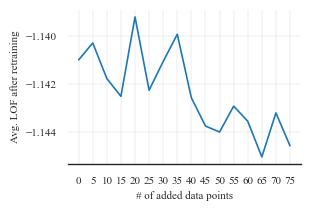

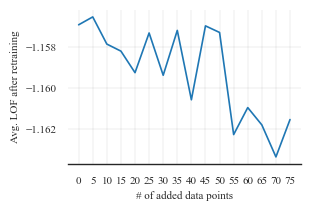

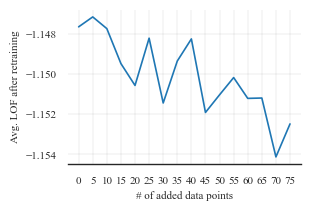

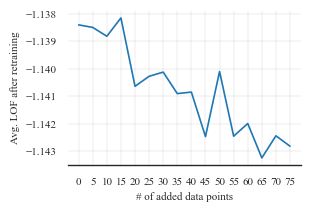

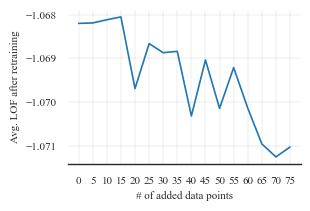

In [21]:
for names,_ in lof_dict_per_model.items():    
    # lof_dict_gen=lof_dict_per_model[names]['genetic']
    lof_dict_rand=lof_dict_per_model[names]['random']
    # lof_dict_kdt=lof_dict_per_model[names]['kdtree']
    acc=acc_dict_per_model[names]
    xval=lof_dict_per_model[names]['random'].keys()
    plt.figure(figsize=(3,2))
    # plt.plot(xval,lof_dict_gen.values(),label='genetic')
    plt.plot(xval,lof_dict_rand.values(),label='')
    # plt.plot(xval,lof_dict_kdt.values(),label='kdtree')
    # plt.plot(xval,acc.values(),label='accuracy')
    plt.xlabel('# of added data points', fontname='Times New Roman',fontsize=8)#fontweight='bold')fontname='Times New Roman',
    plt.ylabel('Avg. LOF after retraining',fontname='Times New Roman',fontsize=8)#, fontweight='bold')
    plt.xticks(rotation=0, fontname='Times New Roman',fontsize=8)#, fontweight='bold')
    plt.yticks(fontname='Times New Roman',fontsize=8)
    # plt.ylim((-10,0))
    
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1)
    plt.grid(True, linestyle='-', linewidth=0.1, color='gray')

    font = fm.FontProperties(family='Times New Roman', size=8) #) weight='bold')
    # plt.legend(prop=font, loc='upper left')


    # plt.legend(prop=font, loc='upper left')

    sns.despine(right=True, left=True, top=True)
    # plt.title(names+' and DiCE')
    plt.show()

In [29]:
print(sr_dict_per_model)

{'rf': 1.0, 'xgb': 1.0, 'lgb': 1.0, 'adb': 1.0, 'ffn': 1.0}


In [27]:
print(lof_dict_per_model)

{'rf': {'random': {'0': -1.1410024905384832, '5': -1.1402937685193946, '10': -1.141781785041171, '15': -1.1425276024251014, '20': -1.1392034077736608, '25': -1.1422703160916046, '30': -1.1410673790448926, '35': -1.1399295582250895, '40': -1.1425912022304177, '45': -1.1437707645700603, '50': -1.1440220265517453, '55': -1.142937717361506, '60': -1.1435710362708045, '65': -1.1450631697712779, '70': -1.1432212018814423, '75': -1.1446002413535041}}, 'xgb': {'random': {'0': -1.1569184252991784, '5': -1.15653532681589, '10': -1.1578560350574316, '15': -1.1581990460226228, '20': -1.1592462041999976, '25': -1.1573157567215264, '30': -1.1593722975663405, '35': -1.157191067150272, '40': -1.160564210129895, '45': -1.156970969093597, '50': -1.1572910321615968, '55': -1.162256643697471, '60': -1.1609443241775506, '65': -1.1617862644730224, '70': -1.1633430287197126, '75': -1.1615263333944552}}, 'lgb': {'random': {'0': -1.1476670435690186, '5': -1.1471753166924685, '10': -1.1477555544164482, '15': -1

In [28]:
print(dist_dict_per_model)

{'rf': {'random': {'0': 3.519476237553483, '5': 3.4992981265637617, '10': 3.480424089658044, '15': 3.520058903629862, '20': 3.4988633078064684, '25': 3.4784811199631283, '30': 3.4864376974797637, '35': 3.487469378610523, '40': 3.5256176324223074, '45': 3.5097805787237157, '50': 3.513059793018863, '55': 3.4828563958377012, '60': 3.5333928041826628, '65': 3.4947012396904475, '70': 3.5008573909410643, '75': 3.499595566834441}}, 'xgb': {'random': {'0': 2.9308129068453788, '5': 2.9214914925193796, '10': 2.9288936043797045, '15': 2.9196303688282854, '20': 2.9233563496874138, '25': 2.8865851916252665, '30': 2.9045207192350553, '35': 2.929218566476682, '40': 2.9109758159542736, '45': 2.89770070238956, '50': 2.92794641804962, '55': 2.930173427329192, '60': 2.8960373217655078, '65': 2.911359150369394, '70': 2.91419396488544, '75': 2.9062933338368753}}, 'lgb': {'random': {'0': 3.4123988033408374, '5': 3.4149992652409535, '10': 3.4237414372151367, '15': 3.3708884923461944, '20': 3.3890495609221256

In [38]:
print(validity_dict_per_model)

{'rf': {'random': {'0': 0.0, '5': 0.1935483870967742, '10': 0.11612903225806452, '15': 0.15483870967741936, '20': 0.12903225806451613, '25': 0.13548387096774195, '30': 0.1935483870967742, '35': 0.15483870967741936, '40': 0.23225806451612904, '45': 0.18064516129032257, '50': 0.14838709677419354, '55': 0.27741935483870966, '60': 0.2709677419354839, '65': 0.24516129032258063, '70': 0.23225806451612904, '75': 0.23870967741935484}}, 'xgb': {'random': {'0': 0.0, '5': 0.1503267973856209, '10': 0.13725490196078433, '15': 0.13725490196078433, '20': 0.13725490196078433, '25': 0.16339869281045752, '30': 0.10457516339869281, '35': 0.16339869281045752, '40': 0.20261437908496732, '45': 0.1503267973856209, '50': 0.17647058823529413, '55': 0.1568627450980392, '60': 0.1503267973856209, '65': 0.12418300653594772, '70': 0.16339869281045752, '75': 0.16993464052287582}}, 'lgb': {'random': {'0': 0.0, '5': 0.13548387096774195, '10': 0.06451612903225806, '15': 0.21935483870967742, '20': 0.17419354838709677, '